# Trace Clustering

In [1]:
import pm4py as pm
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.statistics.traces.generic.log import case_statistics

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
path = os.path.join(os.getcwd(),'Sepsis Cases - Event Log_1_all', 'Sepsis Cases - Event Log.xes')
xes = pm.read_xes(path)


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

## Understanding of Data

In [4]:
df = pm.convert_to_dataframe(xes)
check = pm.convert_to_dataframe(xes)

case_ids = df['case:concept:name'].unique() # extract case ids

activities = df['concept:name'].unique() # extract activities

## Preprocessing of the Data

In [5]:
# mapping activities
mapping = {act: chr(97 + i) for i, act in enumerate(activities)} 
df['activity_mapped'] = df['concept:name'].map(mapping)

trace_ordered_df = df.sort_values(by=["case:concept:name", "time:timestamp"]) # order by case ids
trace_mapped_df = trace_ordered_df.groupby("case:concept:name")["activity_mapped"].apply(list).reset_index() # group by case ids

In [6]:
trace_mapped_df.head()

,case:concept:name,activity_mapped
0,A,"[a, b, c, d, e, f, g, h, i, c, b, b, c, b, c, ..."
1,AA,"[a, e, f, b, d, c, g, h]"
2,AAA,"[a, e, f, g, b, c, d, h, i, j, k]"
3,AB,"[a, e, f, c, d, b, g, h]"
4,ABA,"[a, e, f, g, d, b, c, h, i, b, c, b, b, c, c, ..."


In [7]:
'''
activity_counts = pd.Series(trace_mapped_df['activity_mapped'].apply(len).to_numpy())

activity_counts.describe()
'''

"\nactivity_counts = pd.Series(trace_mapped_df['activity_mapped'].apply(len).to_numpy())\n\nactivity_counts.describe()\n"

## Feature Generation and Transformation

In [8]:
trace_mapped_df['activity_str'] = trace_mapped_df['activity_mapped'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    stop_words=None,                     
    token_pattern=r'(?u)\b\w+\b'         
)

X = vectorizer.fit_transform(trace_mapped_df['activity_str'])

In [9]:
# Just to check the ngrams
feature_names = vectorizer.get_feature_names_out()
X_df = pd.DataFrame(X.toarray(), columns=feature_names)

X_df.head()

,a b,a c,a d,a e,a f,a g,a l,b a,b b,b c,...,l b,l c,l d,l f,l i,l l,m i,n k,o k,p k
0,1,0,0,0,0,0,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,3,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

In [10]:
'''
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

print(svd.explained_variance_ratio_.sum()) # small loss of the information, but less number of features
'''

'\nsvd = TruncatedSVD(n_components=50)\nX_svd = svd.fit_transform(X)\n\nprint(svd.explained_variance_ratio_.sum()) # small loss of the information, but less number of features\n'

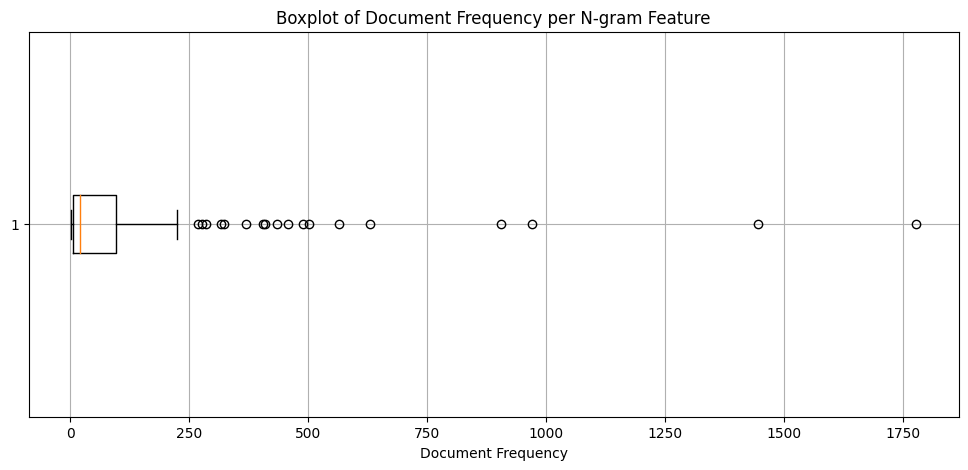

In [11]:
df_counts = np.asarray(X.sum(axis=0)).flatten()

plt.figure(figsize=(12, 5))
plt.boxplot(df_counts, vert=False)
plt.title("Boxplot of Document Frequency per N-gram Feature")
plt.xlabel("Document Frequency")
plt.grid(True)
plt.show()

There is a clear reduction of data points after 500. So the threshold will be set to 500

In [12]:
# number of ngrams remaining after reducing

# Based on IQR
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

idx_1500 = np.where((df_counts >= lower) & (df_counts <= upper))[0]
X_IQR = X[:, idx_1500]

# Based on Boxplot
idx_500 = np.where(df_counts <= 500)[0]
X_box = X[:, idx_500]

print(f"Original number of ngrams: {X.shape[1]}")
print(f"Based on IQR: {X_IQR.shape[1]}")
print(f"Based on Box plot: {X_box.shape[1]}")

Original number of ngrams: 115
Based on IQR: 97
Based on Box plot: 108


In [13]:
#Frequency Feature Selection (IQR)

# 1. frequency of ngrams
df_counts = np.asarray(X.sum(axis=0)).flatten()

# 2. IQR 
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

# 3. Lower, Upper IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Reduce ngrams
valid_idx = np.where((df_counts >= lower) & (df_counts <= upper))[0]

# 5. Filter
X_filtered_iqr = X[:, valid_idx]
X_svd = X_filtered_iqr
#Traces in Cluster 0: 872
#Traces in Cluster 1: 178

In [14]:
svd = TruncatedSVD(n_components=50) # clusters worse as n_components increases
X_svd = svd.fit_transform(X_filtered_iqr)

print(svd.explained_variance_ratio_.sum())

#Traces in Cluster 0: 872
#Traces in Cluster 1: 178

0.957712512471037


In [15]:

#Frequency Feature Selection (Box plot) (selected)

# 1. frequency of ngrams
df_counts = np.asarray(X.sum(axis=0)).flatten()

# 2. IQR 
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

# 3. Lower, Upper IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Reduce ngrams
valid_idx = np.where(df_counts <= 500)[0]

# 5. Filter
X_filtered_box = X[:, valid_idx]
X_svd = X_filtered_box
# Traces in Cluster 0: 1045
#Traces in Cluster 1: 5


In [16]:

svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X_filtered_box)

print(svd.explained_variance_ratio_.sum())

#Traces in Cluster 0: 1047
#Traces in Cluster 1: 3


0.9760176573471038


In [17]:
'''
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

print(svd.explained_variance_ratio_.sum())

#Traces in Cluster 0: 1045
#Traces in Cluster 1: 5
'''

'\nsvd = TruncatedSVD(n_components=50)\nX_svd = svd.fit_transform(X)\n\nprint(svd.explained_variance_ratio_.sum())\n\n#Traces in Cluster 0: 1045\n#Traces in Cluster 1: 5\n'

## Clustering

### Looking for Optimal K

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kme

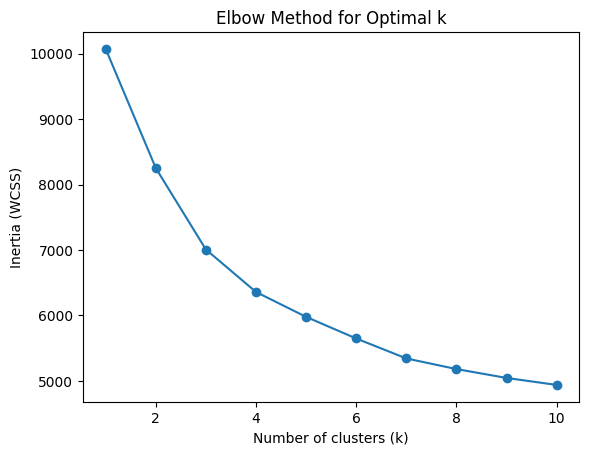

In [18]:
inertia_list = []

for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_svd)  
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kme

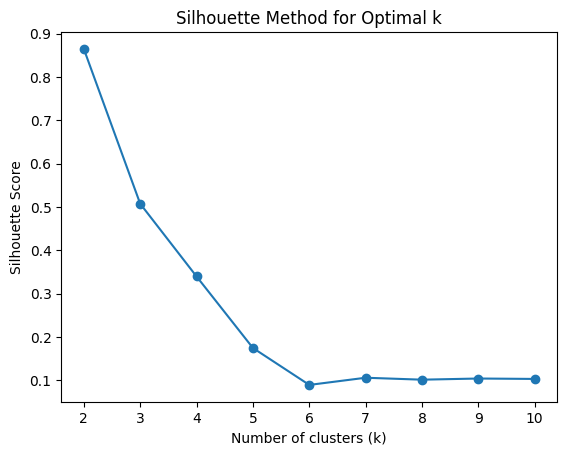

In [19]:
score = []

for i in range(2, 11) :
    km = KMeans(n_clusters = i, random_state = 10)
    km.fit(X_svd)
    pred = km.predict(X_svd)
    score.append(silhouette_score(X_svd, pred))

plt.plot(range(2, 11), score, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()


2 seems to be the best k for this dataset

### Model training

In [20]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_svd)

trace_mapped_df['cluster'] = kmeans.labels_

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [21]:
trace_mapped_df.head()

,case:concept:name,activity_mapped,activity_str,cluster
0,A,"[a, b, c, d, e, f, g, h, i, c, b, b, c, b, c, ...",a b c d e f g h i c b b c b c c b b c c b j,1
1,AA,"[a, e, f, b, d, c, g, h]",a e f b d c g h,1
2,AAA,"[a, e, f, g, b, c, d, h, i, j, k]",a e f g b c d h i j k,1
3,AB,"[a, e, f, c, d, b, g, h]",a e f c d b g h,1
4,ABA,"[a, e, f, g, d, b, c, h, i, b, c, b, b, c, c, ...",a e f g d b c h i b c b b c c b j,1


In [22]:
cluster_counts = trace_mapped_df['cluster'].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    print(f"Traces in Cluster {cluster_id}: {count}")

Traces in Cluster 0: 17
Traces in Cluster 1: 1033


## Process Discovery

In [23]:
def split_event_log_by_cluster(trace_df, full_event_df):
    cluster_logs = {}
    for cluster_id in trace_df['cluster'].unique():
        case_ids = trace_df[trace_df['cluster'] == cluster_id]['case:concept:name']
        cluster_df = full_event_df[full_event_df['case:concept:name'].isin(case_ids)]

        cluster_df = dataframe_utils.convert_timestamp_columns_in_df(cluster_df)
        cluster_logs[cluster_id] = cluster_df

    return cluster_logs


def discover_process_models(cluster_logs, visualize=True):
    cluster_models = {}
    for cluster_id, cluster_df in cluster_logs.items():
        log = log_converter.apply(cluster_df, variant=log_converter.Variants.TO_EVENT_LOG)

        tree = inductive_miner.apply(log)
        net, im, fm = tree_to_petri.apply(tree)
        cluster_models[cluster_id] = (net, im, fm)

        if visualize:
            gviz = pn_visualizer.apply(net, im, fm)
            pn_visualizer.view(gviz)

    return cluster_models

In [24]:
def discover_process_models_by_cluster(trace_df, full_event_df):
    cluster_models = {}
    for cluster_id in trace_df['cluster'].unique():
        
        case_ids = trace_df[trace_df['cluster'] == cluster_id]['case:concept:name']
        cluster_df = full_event_df[full_event_df['case:concept:name'].isin(case_ids)]

        cluster_df = dataframe_utils.convert_timestamp_columns_in_df(cluster_df)
        log = log_converter.apply(cluster_df, variant=log_converter.Variants.TO_EVENT_LOG)

        tree = inductive_miner.apply(log)
        net, im, fm = tree_to_petri.apply(tree)
        cluster_models[cluster_id] = (net, im, fm)

        gviz = pn_visualizer.apply(net, im, fm);
        pn_visualizer.view(gviz)

    return cluster_models

In [25]:
def evaluate_models_cluster(models_dict, trace_df, full_event_df, case_col='case:concept:name', act_col='concept:name', time_col='time:timestamp'):
    results = []

    for cluster_id, (net, im, fm) in models_dict.items():
        case_ids = trace_df[trace_df['cluster'] == cluster_id][case_col]
        sublog = full_event_df[full_event_df[case_col].isin(case_ids)].copy()

        if sublog.empty:
            continue

        sublog = dataframe_utils.convert_timestamp_columns_in_df(sublog)
        event_log = log_converter.apply(sublog)

        num_places = len(net.places)
        num_transitions = len(net.transitions)
        num_nodes = num_places + num_transitions
        num_arcs = len(net.arcs)

        cnc = num_arcs / num_nodes if num_nodes else 0
        pt_cd = 0.5 * (num_arcs / num_places + num_arcs / num_transitions) if num_places and num_transitions else 0
        cyclomatic_number = num_arcs - num_nodes + 1

        connector_degrees = [len(p.in_arcs) + len(p.out_arcs) for p in net.places] + \
                            [len(t.in_arcs) + len(t.out_arcs) for t in net.transitions]
        acd = sum(connector_degrees) / len(connector_degrees) if connector_degrees else 0

        density = num_arcs / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
        cfc = sum(len(t.out_arcs) for t in net.transitions if len(t.out_arcs) > 1)

        variants = case_statistics.get_variant_statistics(event_log)
        num_variants = len(variants)
        event_classes = set(event[act_col] for trace in event_log for event in trace)
        num_event_classes = len(event_classes)

        results.append({
            "Cluster": cluster_id,
            "# Nodes": num_nodes,
            "# Arcs": num_arcs,
            "CNC": cnc,
            "P/T-CD": pt_cd,
            "Cyclomatic Number (CN)": cyclomatic_number,
            "ACD": acd,
            "Density": density,
            "CFC": cfc,
            "# Event Classes": num_event_classes,
            "# Variants": num_variants,
            "# Events": len(sublog)
        })

    return pd.DataFrame(results)


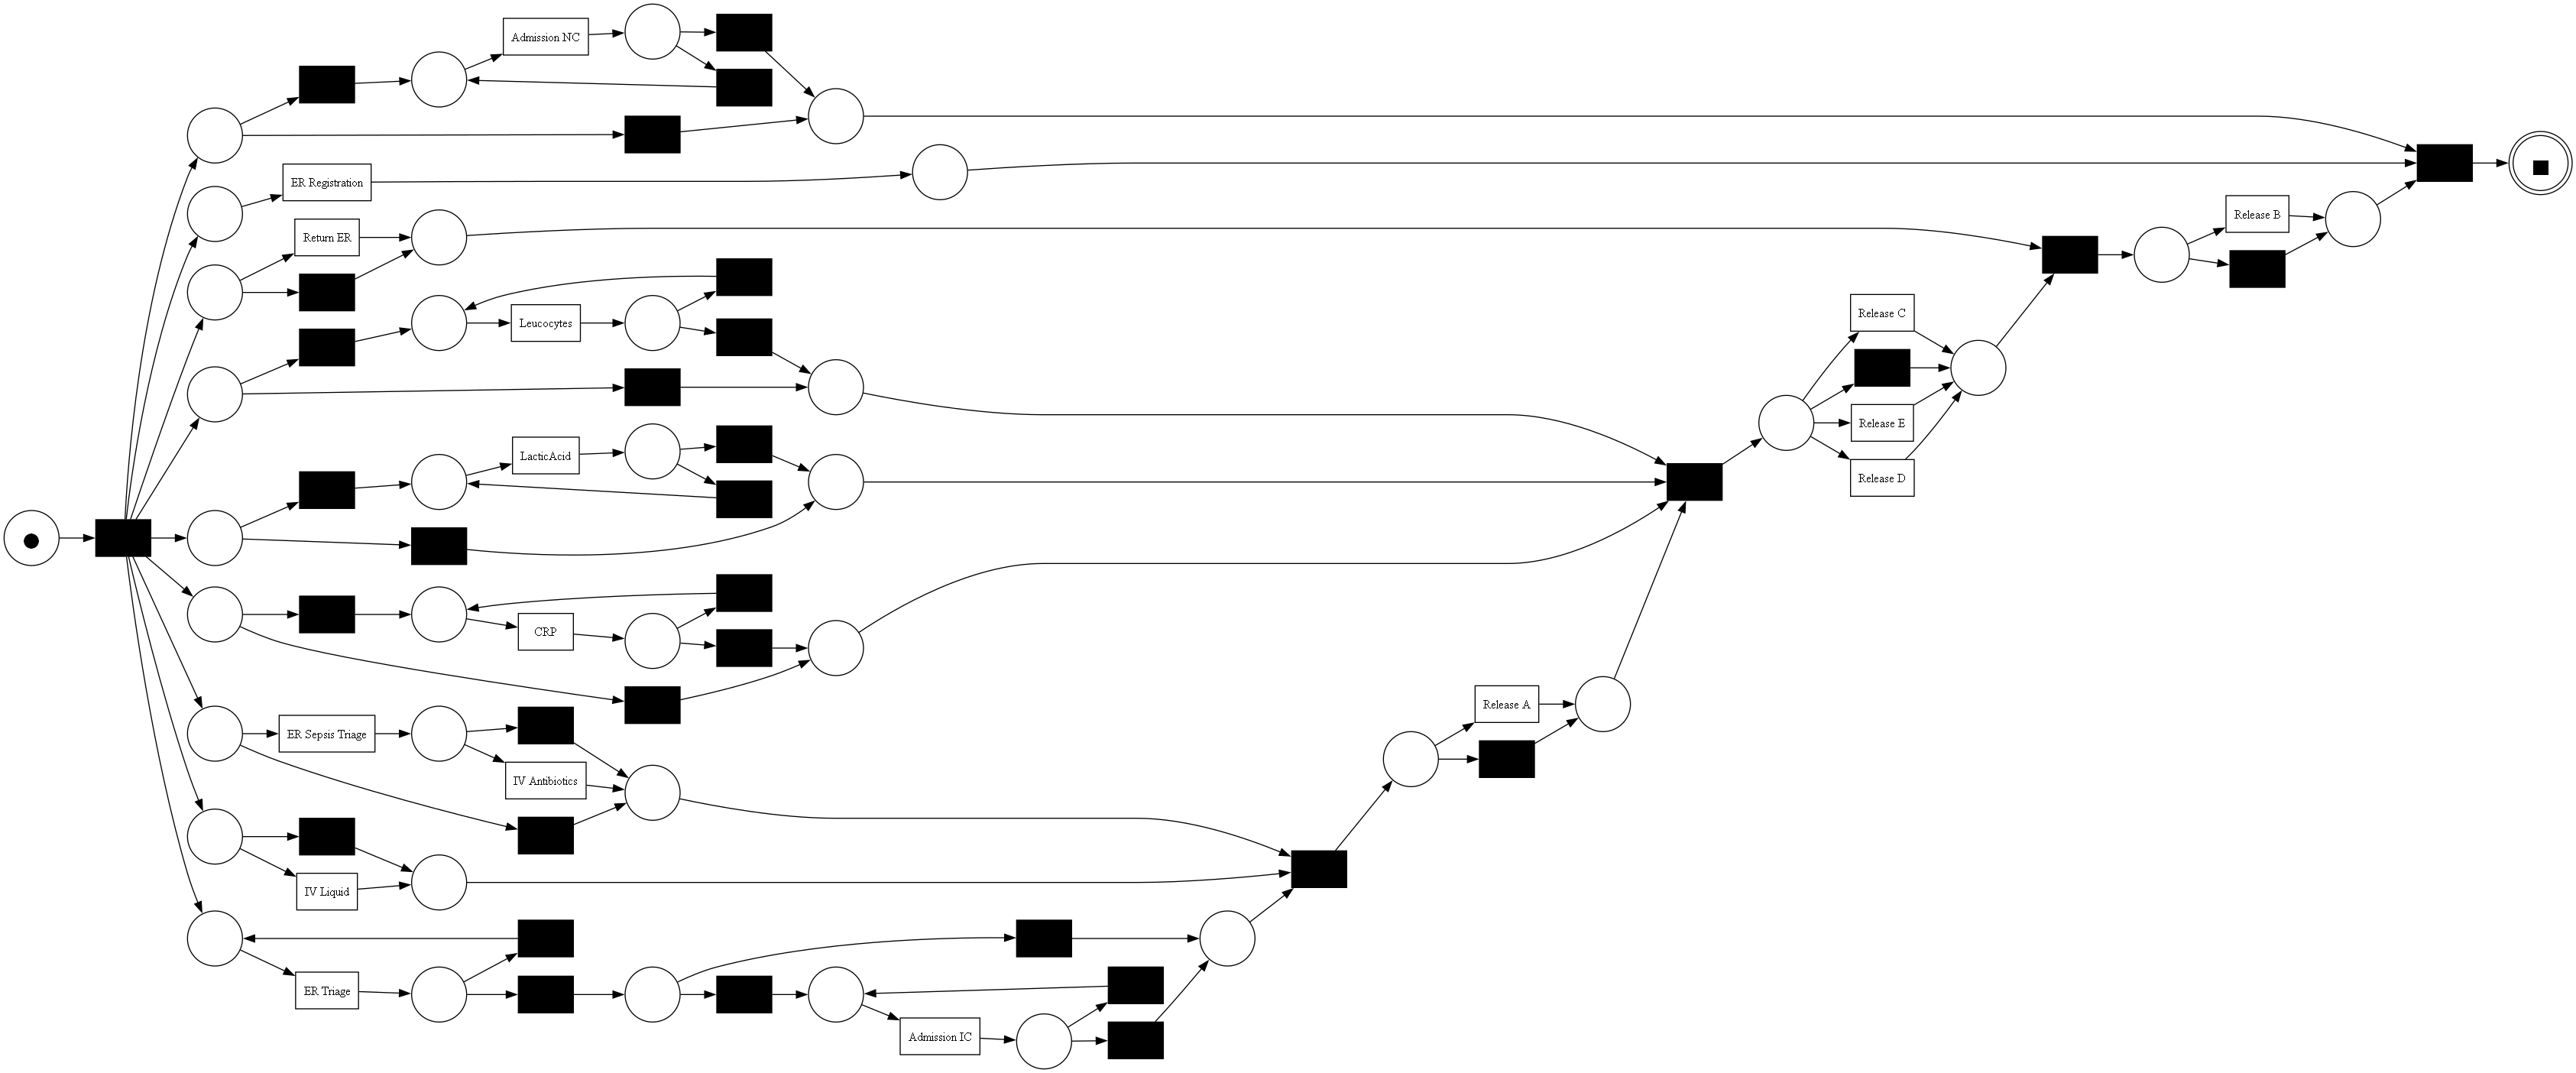

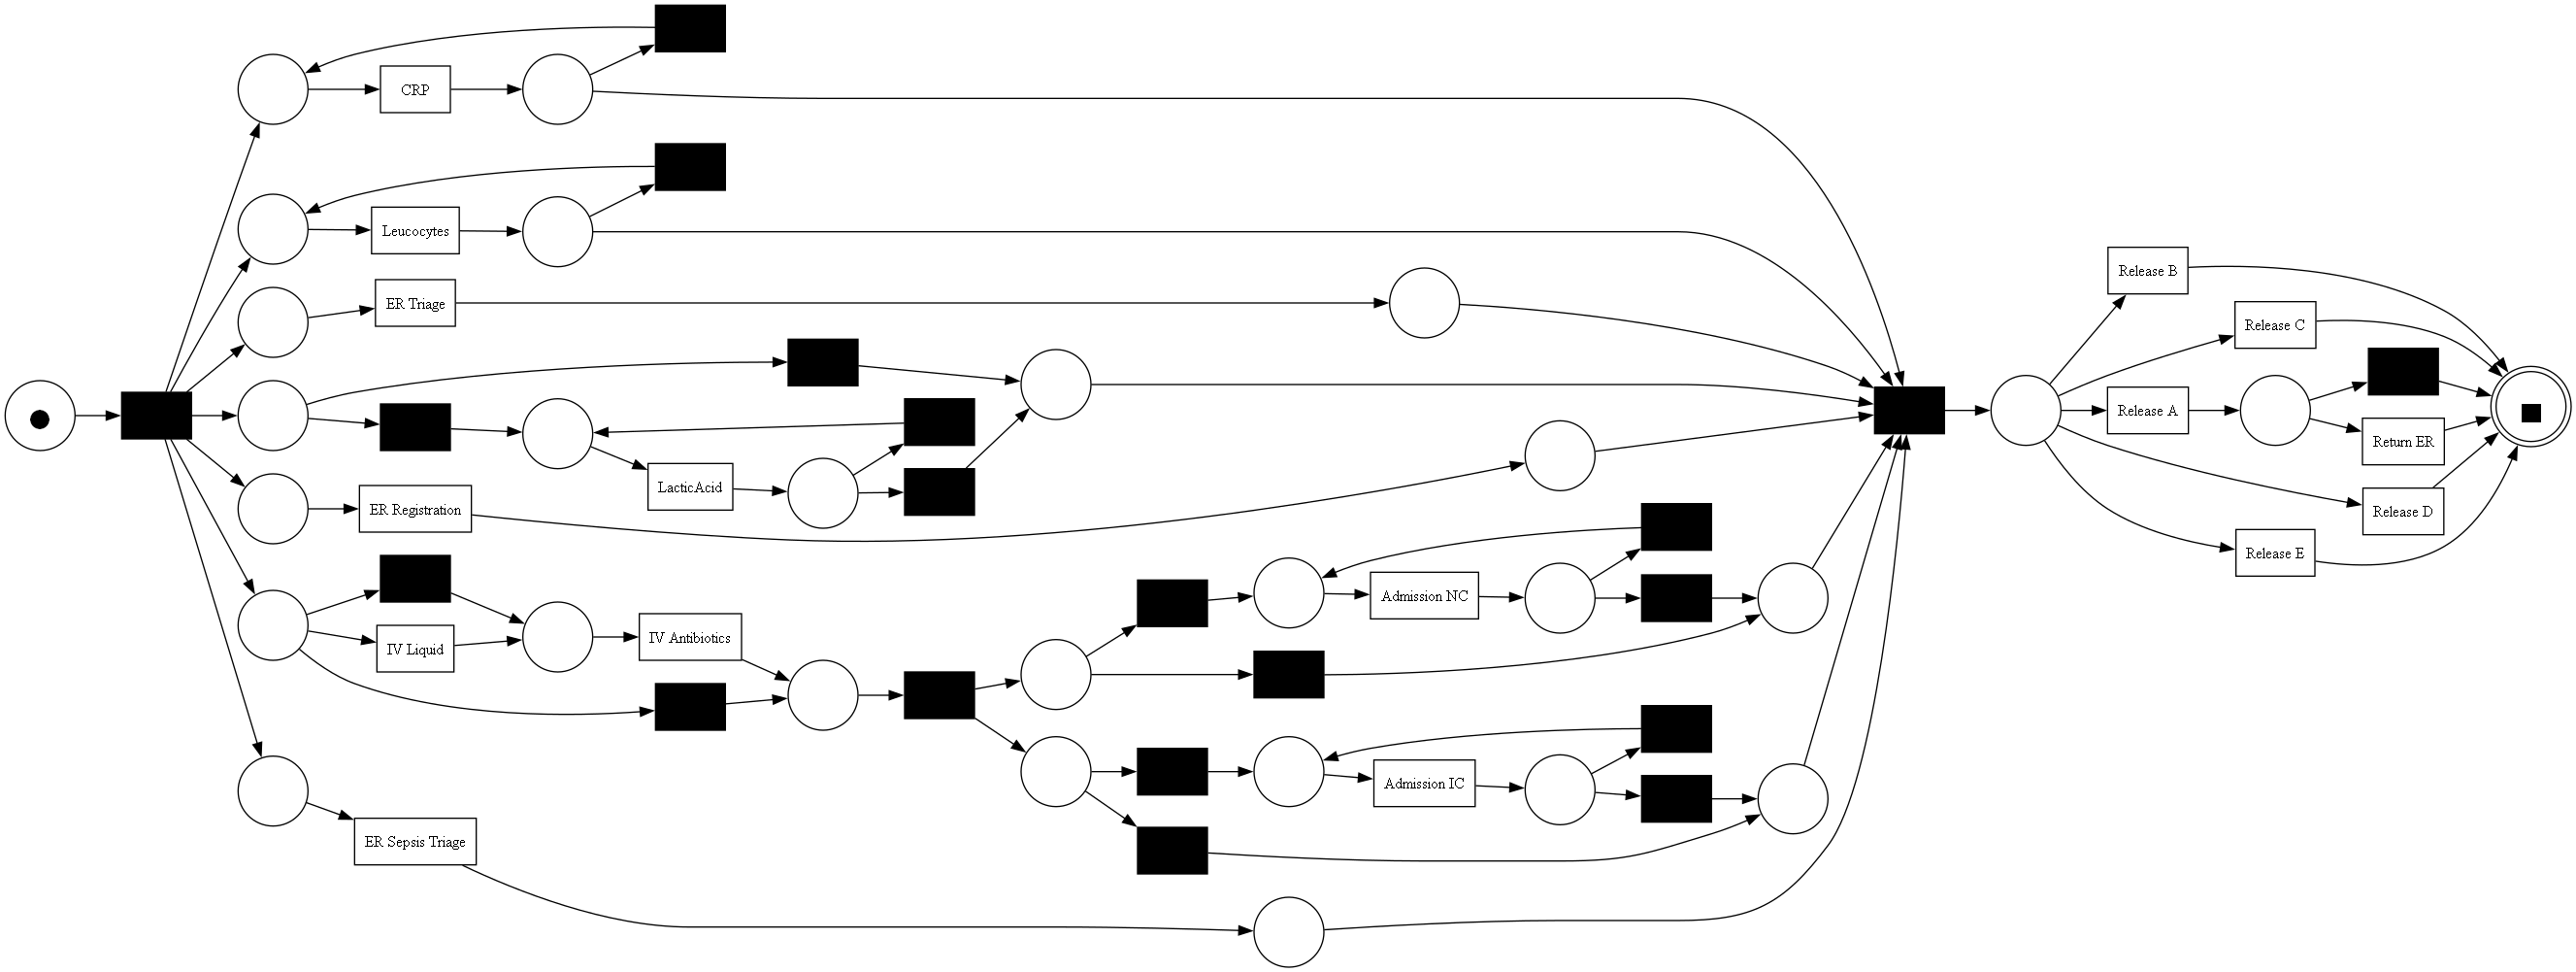

In [26]:
#cluster_models = discover_process_models_by_cluster(trace_mapped_df, trace_ordered_df)
cluster_logs = split_event_log_by_cluster(trace_mapped_df, trace_ordered_df)
cluster_models = discover_process_models(cluster_logs)

In [27]:
results_df_tc = evaluate_models_cluster(
    models_dict=cluster_models,
    trace_df=trace_mapped_df,
    full_event_df=trace_ordered_df
)

In [28]:
results_df_tc

,Cluster,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,1,89,116,1.303371,2.647179,28,2.606742,0.014811,9,16,829,14073
1,0,65,86,1.323077,2.677203,22,2.646154,0.020673,9,16,17,1141


# Process Cube

In [29]:
import pandas as pd
import numpy as np
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import pm4py as pm
import os
import copy
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.statistics.traces.generic.log import case_statistics

In [30]:
path = os.path.join(os.getcwd(),'Sepsis Cases - Event Log_1_all', 'Sepsis Cases - Event Log.xes')
xes = pm.read_xes(path)
df = pm.convert_to_dataframe(xes)
check = copy.deepcopy(df)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

## Functions

In [31]:
def define_age_hierarchy(df):
    df['age_group'] = pd.cut(df['Age'], 
                             bins=[0, 7, 13, 19, 30, 40, 50, 60, 70, 80, 150], 
                             labels=['0-6', '7-12', '13-18', '19-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'],
                             right=False)
    df['age_category'] = df['age_group'].map({
        '0-6': 'Child',
        '7-12': 'Child',
        '13-18': 'Teen',
        '19-29': 'Young Adult',
        '30-39': 'Adult',
        '40-49': 'Adult',
        '50-59': 'Middle-aged',
        '60-69': 'Middle-aged',
        '70-79': 'Senior',
        '80+': 'Senior'
    })
    return df

def define_time_hierarchy(df):
    df['timestamp'] = pd.to_datetime(df['time:timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    return df

def define_activity_groups(df):
    activity_group_map = {
        'Admission IC': 'Admission',
        'Admission NC': 'Admission',
        'ER Registration': 'Emergency',
        'ER Triage': 'Emergency',
        'ER Sepsis Triage': 'Emergency',
        'Return ER': 'Emergency',
        'Leucocytes': 'Test',
        'CRP': 'Test',
        'LacticAcid': 'Test',
        'IV Antibiotics': 'Treatment',
        'IV Liquid': 'Treatment',
        'Release A': 'Release',
        'Release B': 'Release',
        'Release C': 'Release',
        'Release D': 'Release',
        'Release E': 'Release'
    }

    df['activity_group'] = df['concept:name'].map(activity_group_map)

    return df

def fill_trace_level_values(df, columns, case_col='case:concept:name'):
    df = df.copy()

    df[columns] = df.groupby(case_col)[columns].transform(lambda group: group.ffill().bfill())
    return df

In [32]:
def build_pcs():
    # 프로세스 큐브 구조 정의
    pcs = {
        'time': {
            'attributes': ['day', 'month', 'year'],
            'hierarchy': [('day', 'month'), ('month', 'year')]
        },
        'age': {
            'attributes': ['Age', 'age_group', 'age_category'],
            'hierarchy': [('Age', 'age_group'), ('age_group', 'age_category')]
        },
        'activity' : {
            'attributes': ['concept:name', 'activity_group'],
            'herarchy': [('concept:name', 'activity_group')]
        }
    }
    return pcs

def build_pcv(granularity: dict, filters: dict = {}):
    pcv = {
        'visible_dimensions': list(granularity.keys()),
        'granularity': granularity,
        'selection': filters
    }
    return pcv


In [33]:
def slice_pcv(pcv, dimension_to_remove, filter_values):
    new_pcv = copy.deepcopy(pcv)
    if dimension_to_remove in new_pcv['visible_dimensions']:
        new_pcv['visible_dimensions'].remove(dimension_to_remove)
    for attr, values in filter_values.items():
        new_pcv['selection'][attr] = values
    return new_pcv

def dice_pcv(pcv, filter_values):
    new_pcv = copy.deepcopy(pcv)
    for attr, values in filter_values.items():
        new_pcv['selection'][attr] = values
    return new_pcv

def rollup_pcv(pcv, pcs, dimension):
    new_pcv = copy.deepcopy(pcv)
    current_attr = new_pcv['granularity'].get(dimension)
    if not current_attr:
        return pcv

    hierarchy = pcs[dimension]['hierarchy']
    for low, high in hierarchy:
        if low == current_attr:
            new_pcv['granularity'][dimension] = high
            return new_pcv
    return pcv 

def drilldown_pcv(pcv, pcs, dimension):
    new_pcv = copy.deepcopy(pcv)
    current_attr = new_pcv['granularity'].get(dimension)
    if not current_attr:
        return pcv

    hierarchy = pcs[dimension]['hierarchy']
    for low, high in hierarchy:
        if high == current_attr:
            new_pcv['granularity'][dimension] = low
            return new_pcv
    return pcv 


In [34]:
def materialize_process_cube_view(df, pcs, pcv):
    filtered_df = df.copy()
    for attr, values in pcv['selection'].items():
        filtered_df = filtered_df[filtered_df[attr].isin(values)]
    
    gran_attrs = [pcv['granularity'][dim] for dim in pcv['visible_dimensions']]

    for attr in gran_attrs:
        if filtered_df[attr].dtype.name == 'category':
            filtered_df[attr] = filtered_df[attr].cat.add_categories('Unknown').fillna('Unknown')
        elif pd.api.types.is_numeric_dtype(filtered_df[attr]):
            filtered_df[attr] = filtered_df[attr].fillna(-1) 
        else:
            filtered_df[attr] = filtered_df[attr].fillna('Unknown')

    cube = {}
    grouped = filtered_df.groupby(gran_attrs)

    for key, group in grouped:
        if not isinstance(key, tuple):
            key = (key,) 
        cube[key] = group.copy()

    return cube # dict (dimensions: sublog)

## Preprocessing

In [35]:
df = define_age_hierarchy(df)
df = define_time_hierarchy(df)
df = define_activity_groups(df)
df = fill_trace_level_values(df, ['Age', 'age_group', 'age_category'])

## PCS

In [36]:
pcs = build_pcs()

## PCV

In [37]:
pcv = build_pcv(
    granularity={'time': 'month', 'age': 'age_group', 'activity': 'activity_group'},
    filters={}
)

## Operations

In [38]:
pcv = rollup_pcv(pcv,pcs,'time')
pcv = rollup_pcv(pcv,pcs,'age')

In [39]:
mpcv = materialize_process_cube_view(df, pcs, pcv)
print(f"Total number of cells: {len(mpcv)}")
for cell_key, sublog in mpcv.items():
    print(f"Cell {cell_key}: {len(sublog)} events")
total_events = sum(len(sublog) for sublog in mpcv.values())
print(f"Total number of events: {total_events}")

Total number of cells: 59
Cell (2013, 'Adult', 'Admission'): 3 events
Cell (2013, 'Adult', 'Emergency'): 9 events
Cell (2013, 'Adult', 'Release'): 1 events
Cell (2013, 'Adult', 'Test'): 14 events
Cell (2013, 'Middle-aged', 'Admission'): 15 events
Cell (2013, 'Middle-aged', 'Emergency'): 30 events
Cell (2013, 'Middle-aged', 'Release'): 6 events
Cell (2013, 'Middle-aged', 'Test'): 119 events
Cell (2013, 'Middle-aged', 'Treatment'): 18 events
Cell (2013, 'Senior', 'Admission'): 75 events
Cell (2013, 'Senior', 'Emergency'): 193 events
Cell (2013, 'Senior', 'Release'): 41 events
Cell (2013, 'Senior', 'Test'): 433 events
Cell (2013, 'Senior', 'Treatment'): 102 events
Cell (2013, 'Young Adult', 'Admission'): 1 events
Cell (2013, 'Young Adult', 'Emergency'): 6 events
Cell (2013, 'Young Adult', 'Release'): 1 events
Cell (2013, 'Young Adult', 'Test'): 6 events
Cell (2013, 'Young Adult', 'Treatment'): 4 events
Cell (2014, 'Adult', 'Admission'): 82 events
Cell (2014, 'Adult', 'Emergency'): 265 eve

In [40]:
cell_data = []

for cell_key, sublog in mpcv.items():
    cell_data.append((*cell_key, len(sublog))) 

filtered_mpcv = pd.DataFrame(cell_data, columns=['year', 'age_category', 'activity_group', 'Event Count'])

top2_per_year = (
    filtered_mpcv.sort_values(['year', 'Event Count'], ascending=[True, False])
      .groupby('year')
      .head(2)
)

print(top2_per_year)

    year age_category activity_group  Event Count
12  2013       Senior           Test          433
10  2013       Senior      Emergency          193
32  2014       Senior           Test         4762
30  2014       Senior      Emergency         1867
52  2015       Senior           Test          345
50  2015       Senior      Emergency          182


In [41]:
cell_list = list(top2_per_year[['year', 'age_category', 'activity_group']].itertuples(index=False, name=None))

In [42]:
def discover_models_for_cells(df, cell_list, case_col='case:concept:name', act_col='concept:name', time_col='time:timestamp'):
    models = {}

    for cell in cell_list:
        year, age_cat, act_group = cell
        sublog = df[
            (df['year'] == year) &
            (df['age_category'] == age_cat) &
            (df['activity_group'] == act_group)
        ]

        if sublog.empty:
            print(f"Cell {cell}: Skip, since no log")
            continue

        print(f"Cell {cell} Number of events: {len(sublog)}")

        sublog = dataframe_utils.convert_timestamp_columns_in_df(sublog)
        event_log = log_converter.apply(sublog, variant=log_converter.Variants.TO_EVENT_LOG)
        tree = inductive_miner.apply(event_log)

        net, im, fm = tree_to_petri.apply(tree)

        gviz = pn_visualizer.apply(net, im, fm)
        pn_visualizer.view(gviz)  

        models[cell] = (net, im, fm)

    return models

In [43]:
df.head()

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,Leucocytes,CRP,LacticAcid,age_group,age_category,timestamp,year,month,day,activity_group
0,True,A,True,True,True,True,True,True,True,ER Registration,...,NaN,NaN,NaN,80+,Senior,2014-10-22 11:15:41+00:00,2014,10,22,Emergency
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,9.6,NaN,NaN,80+,Senior,2014-10-22 11:27:00+00:00,2014,10,22,Test
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,21.0,NaN,80+,Senior,2014-10-22 11:27:00+00:00,2014,10,22,Test
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,NaN,2.2,80+,Senior,2014-10-22 11:27:00+00:00,2014,10,22,Test
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,NaN,NaN,80+,Senior,2014-10-22 11:33:37+00:00,2014,10,22,Emergency


Cell (2013, 'Senior', 'Test') Number of events: 433


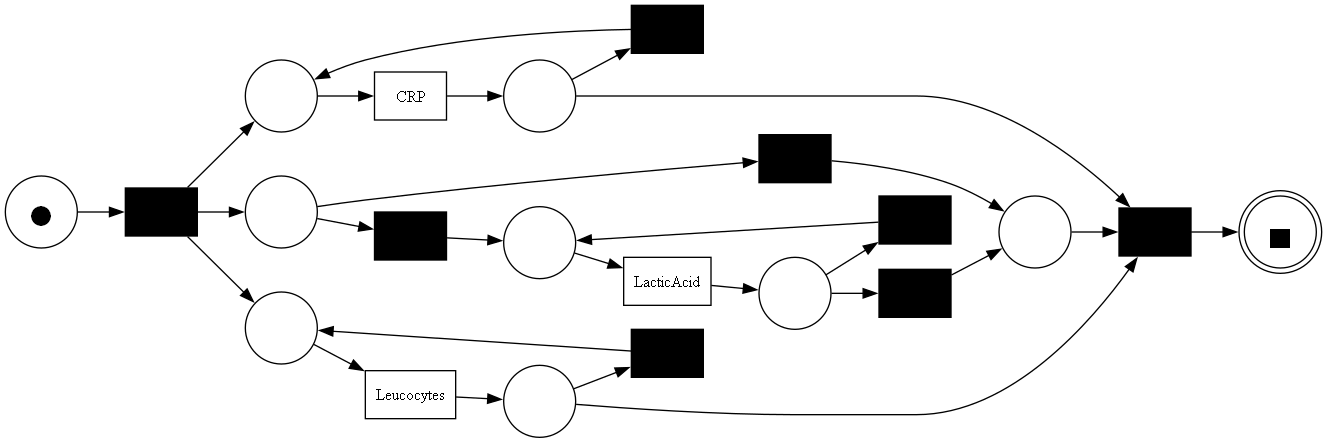

Cell (2013, 'Senior', 'Emergency') Number of events: 193


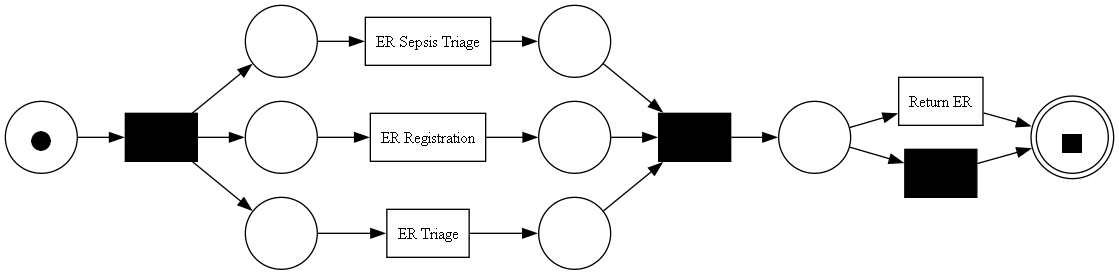

Cell (2014, 'Senior', 'Test') Number of events: 4762


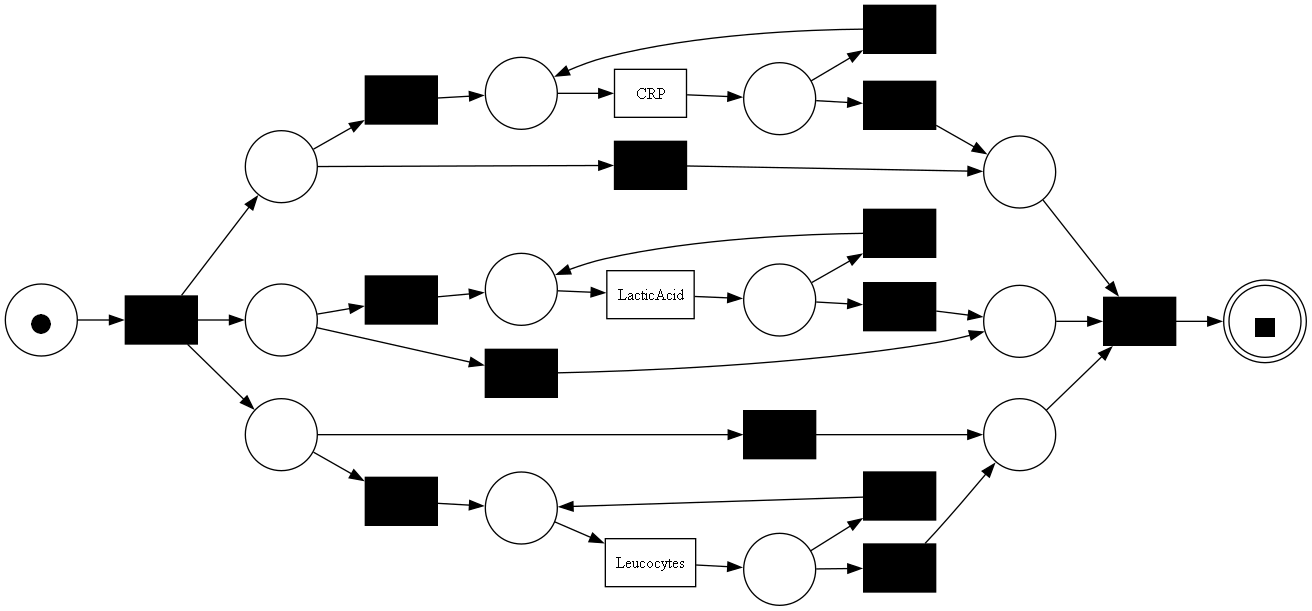

Cell (2014, 'Senior', 'Emergency') Number of events: 1867


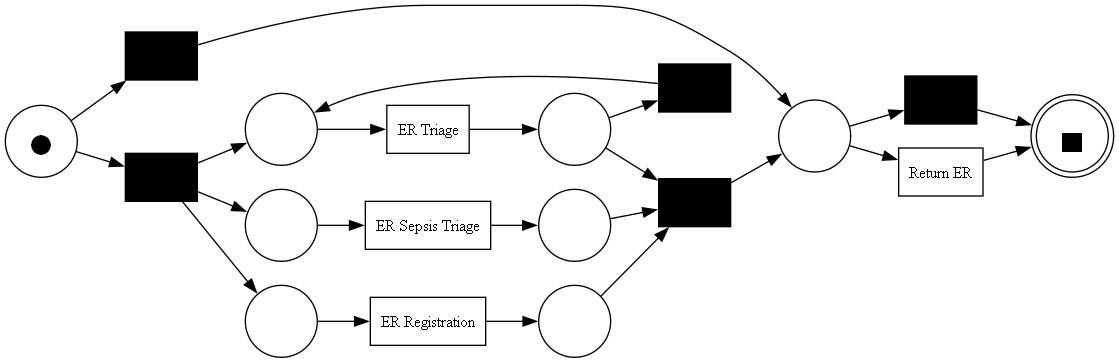

Cell (2015, 'Senior', 'Test') Number of events: 345


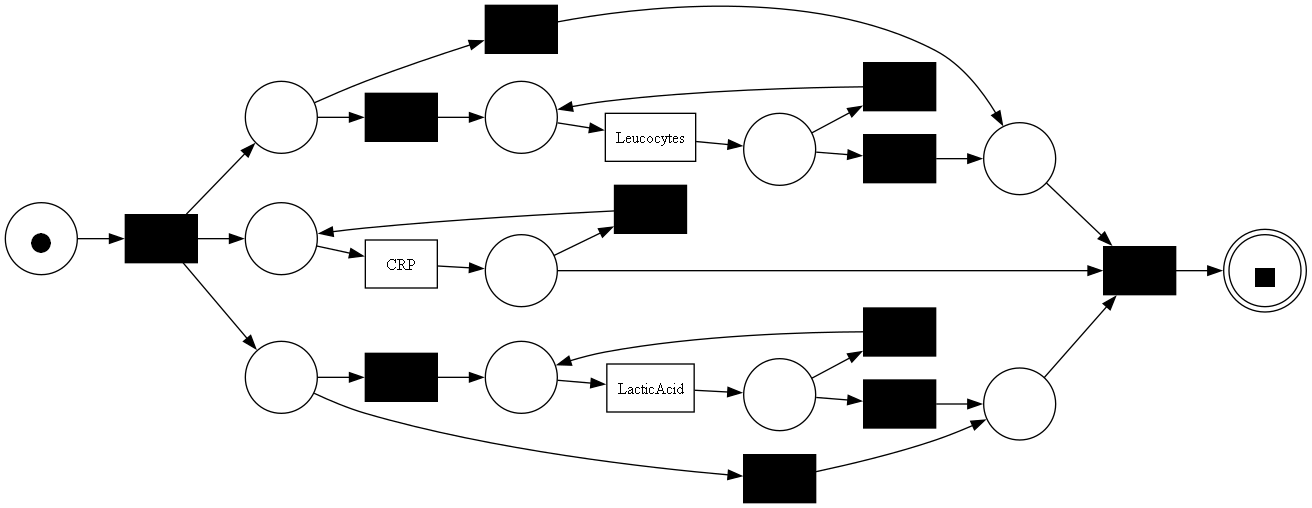

Cell (2015, 'Senior', 'Emergency') Number of events: 182


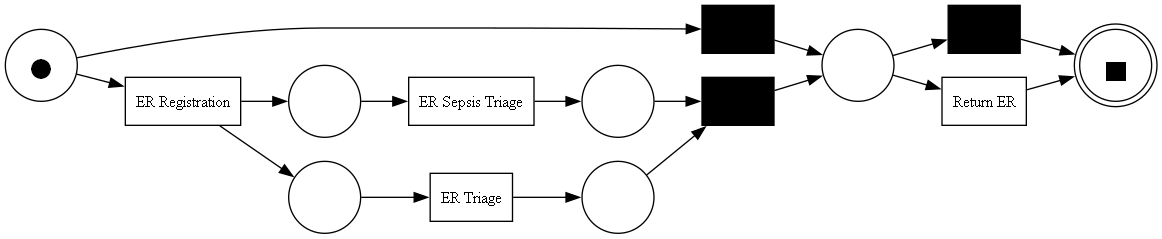

In [44]:
models = discover_models_for_cells(df, cell_list)

In [45]:
def evaluate_models_pc(df, models_dict, case_col='case:concept:name', act_col='concept:name', time_col='time:timestamp'):
    results = []

    for cell_key, (net, im, fm) in models_dict.items():
        year, age_cat, act_group = cell_key

        sublog = df[
            (df['year'] == year) &
            (df['age_category'] == age_cat) &
            (df['activity_group'] == act_group)
        ].copy()

        if sublog.empty:
            continue

        sublog = dataframe_utils.convert_timestamp_columns_in_df(sublog)
        event_log = log_converter.apply(sublog)

        num_places = len(net.places)
        num_transitions = len(net.transitions)
        num_nodes = num_places + num_transitions
        num_arcs = len(net.arcs)

        cnc = num_arcs / num_nodes if num_nodes else 0
        pt_cd = 0.5 * (num_arcs / num_places + num_arcs / num_transitions) if num_places and num_transitions else 0
        cyclomatic_number = num_arcs - num_nodes + 1

        connector_degrees = [len(p.in_arcs) + len(p.out_arcs) for p in net.places] + \
                            [len(t.in_arcs) + len(t.out_arcs) for t in net.transitions]
        acd = sum(connector_degrees) / len(connector_degrees) if connector_degrees else 0

        density = num_arcs / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
        cfc = sum(len(t.out_arcs) for t in net.transitions if len(t.out_arcs) > 1)

        variants = case_statistics.get_variant_statistics(event_log)
        num_variants = len(variants)
        event_classes = set(event["concept:name"] for trace in event_log for event in trace)
        num_event_classes = len(event_classes)

        results.append({
            "Cell": cell_key,
            "# Nodes": num_nodes,
            "# Arcs": num_arcs,
            # High CNC means increase of complexity (cycles are more challenging to understand than sequential ones)
            "CNC": cnc, # Arcs/Nodes
            "P/T-CD": pt_cd, # Density of arcs between transitions and places
            "Cyclomatic Number (CN)": cyclomatic_number, # the number of linearly independent paths in a process model (No repetitions in the path)
            "ACD": acd, # Average of number of arcs in/out from the connectors
            "Density": density, # actual number of arcs/possible number of arcs
            "CFC": cfc,# Aggregate of out-degree of splits (e.g. OR, XOR, AND)
            "# Event Classes": num_event_classes,
            "# Variants": num_variants,
            "# Events": len(sublog)
        })

    return pd.DataFrame(results)

## Differences in terms of output
## Comparison of the output
# at 3 on tuesday

In [46]:
results_df_pc = evaluate_models_pc(df, models)

In [47]:
results_df_pc

,Cell,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,"(2013, Senior, Test)",21,26,1.238095,2.481818,6,2.476190,0.061905,3,3,48,433
1,"(2013, Senior, Emergency)",16,18,1.125000,2.285714,3,2.250000,0.075000,3,4,4,193
2,"(2014, Senior, Test)",31,38,1.225806,2.474790,8,2.451613,0.040860,3,3,276,4762
3,"(2014, Senior, Emergency)",18,22,1.222222,2.444444,5,2.444444,0.071895,3,4,10,1867
4,"(2015, Senior, Test)",26,32,1.230769,2.476190,7,2.461538,0.049231,3,3,42,345
5,"(2015, Senior, Emergency)",14,16,1.142857,2.285714,3,2.285714,0.087912,2,4,4,182


In [48]:
results_df_tc

,Cluster,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,1,89,116,1.303371,2.647179,28,2.606742,0.014811,9,16,829,14073
1,0,65,86,1.323077,2.677203,22,2.646154,0.020673,9,16,17,1141


# TC --> PC

Total number of Cells: 59
Cell (2013, 'Adult', 'Admission'): 3 events
Cell (2013, 'Adult', 'Emergency'): 9 events
Cell (2013, 'Adult', 'Release'): 1 events
Cell (2013, 'Adult', 'Test'): 14 events
Cell (2013, 'Middle-aged', 'Admission'): 15 events
Cell (2013, 'Middle-aged', 'Emergency'): 30 events
Cell (2013, 'Middle-aged', 'Release'): 6 events
Cell (2013, 'Middle-aged', 'Test'): 119 events
Cell (2013, 'Middle-aged', 'Treatment'): 18 events
Cell (2013, 'Senior', 'Admission'): 75 events
Cell (2013, 'Senior', 'Emergency'): 193 events
Cell (2013, 'Senior', 'Release'): 41 events
Cell (2013, 'Senior', 'Test'): 433 events
Cell (2013, 'Senior', 'Treatment'): 102 events
Cell (2013, 'Young Adult', 'Admission'): 1 events
Cell (2013, 'Young Adult', 'Emergency'): 6 events
Cell (2013, 'Young Adult', 'Release'): 1 events
Cell (2013, 'Young Adult', 'Test'): 6 events
Cell (2013, 'Young Adult', 'Treatment'): 4 events
Cell (2014, 'Adult', 'Admission'): 80 events
Cell (2014, 'Adult', 'Emergency'): 261 eve

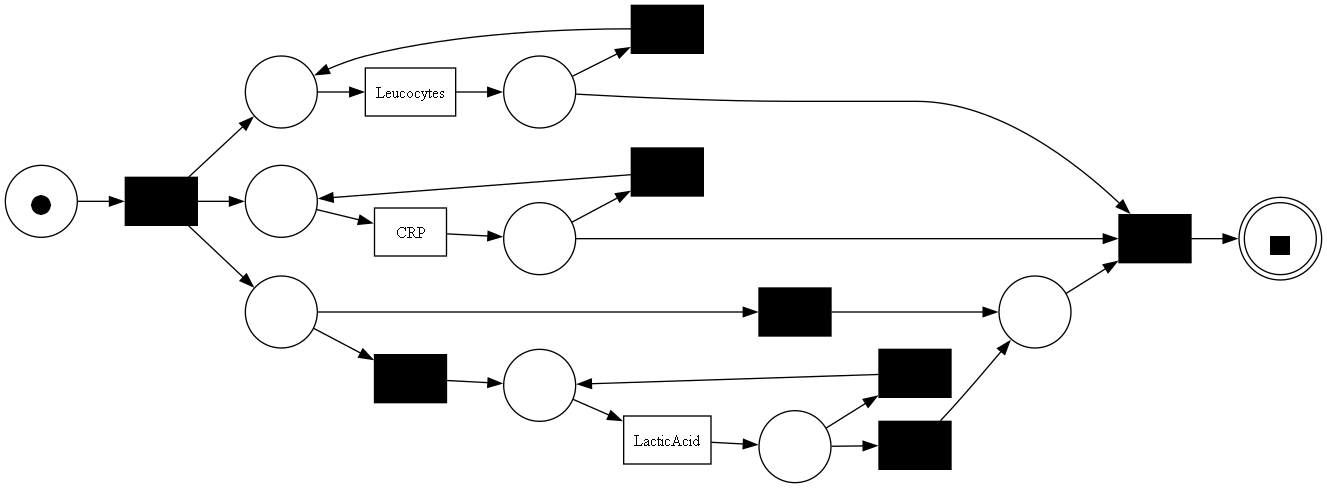

Cell (2013, 'Senior', 'Emergency') Number of events: 193


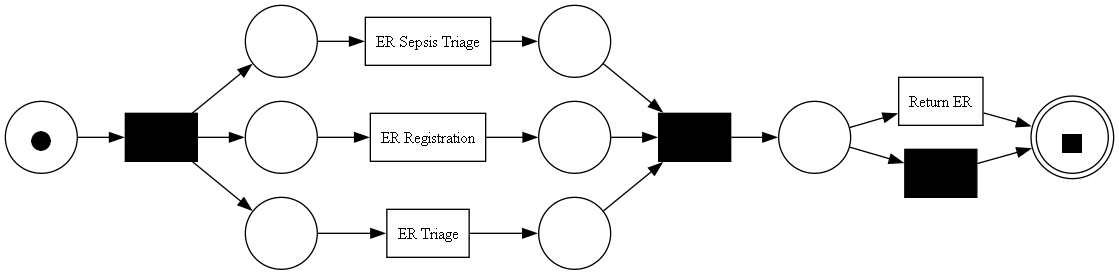

Cell (2014, 'Senior', 'Test') Number of events: 3988


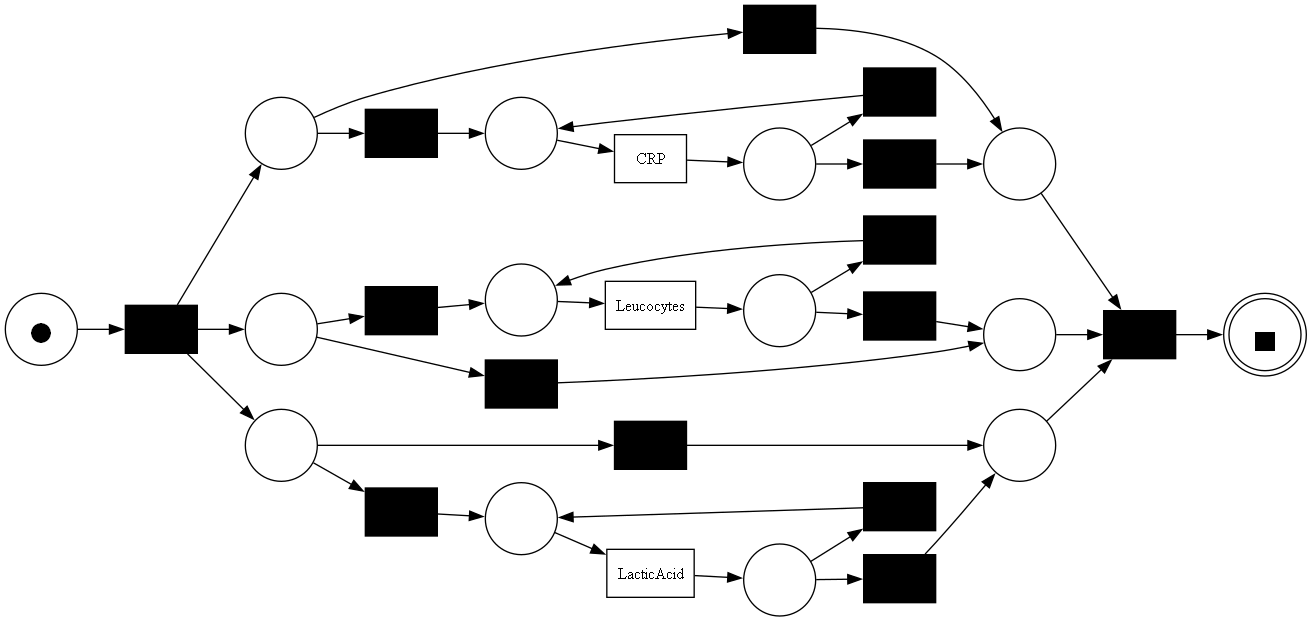

Cell (2014, 'Senior', 'Emergency') Number of events: 1823


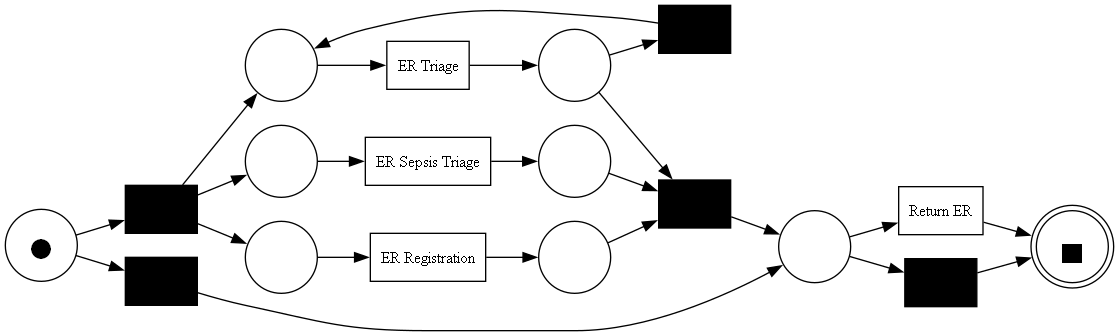

Cell (2015, 'Senior', 'Test') Number of events: 345


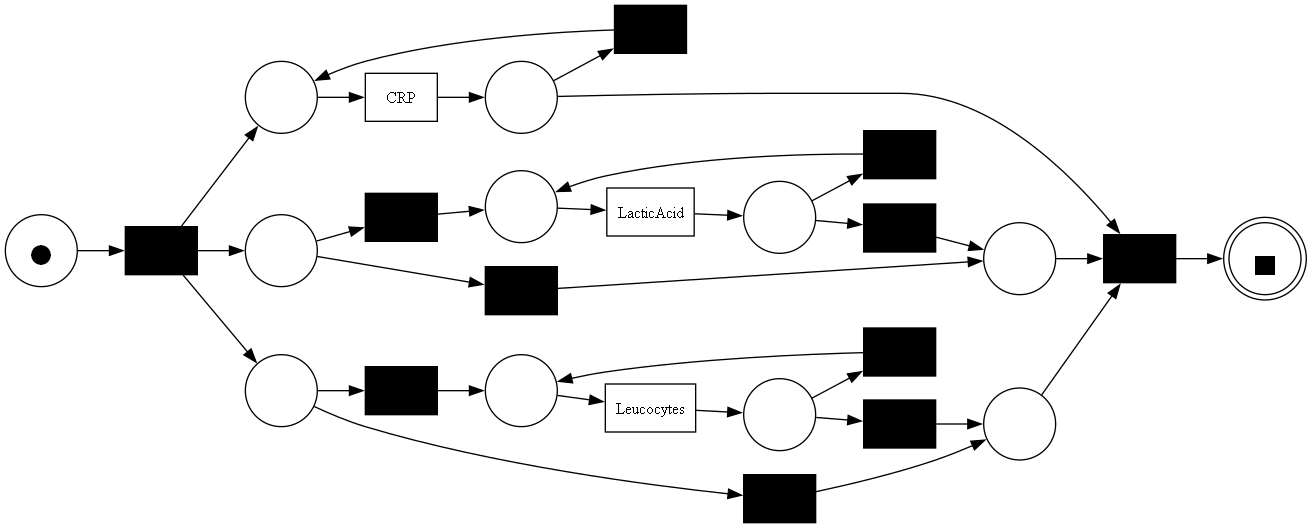

Cell (2015, 'Senior', 'Emergency') Number of events: 182


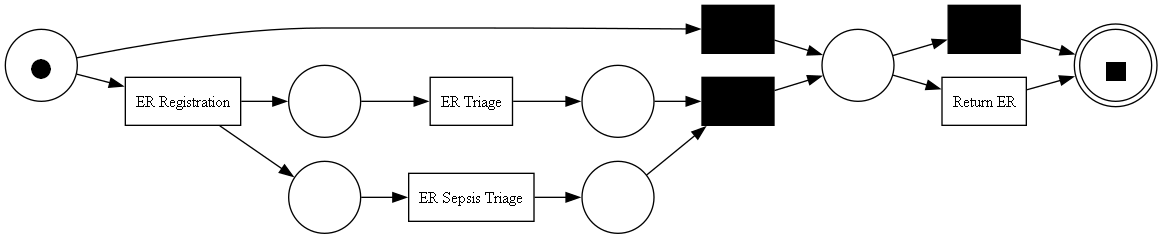

Total number of Cells: 18
Cell (2014, 'Adult', 'Admission'): 2 events
Cell (2014, 'Adult', 'Emergency'): 4 events
Cell (2014, 'Adult', 'Release'): 1 events
Cell (2014, 'Adult', 'Test'): 50 events
Cell (2014, 'Adult', 'Treatment'): 2 events
Cell (2014, 'Middle-aged', 'Admission'): 8 events
Cell (2014, 'Middle-aged', 'Emergency'): 9 events
Cell (2014, 'Middle-aged', 'Release'): 2 events
Cell (2014, 'Middle-aged', 'Test'): 106 events
Cell (2014, 'Middle-aged', 'Treatment'): 4 events
Cell (2014, 'Senior', 'Admission'): 37 events
Cell (2014, 'Senior', 'Emergency'): 44 events
Cell (2014, 'Senior', 'Release'): 13 events
Cell (2014, 'Senior', 'Test'): 774 events
Cell (2014, 'Senior', 'Treatment'): 19 events
Cell (2015, 'Middle-aged', 'Admission'): 2 events
Cell (2015, 'Middle-aged', 'Release'): 1 events
Cell (2015, 'Middle-aged', 'Test'): 63 events
Total number of events: 1141
    year age_category activity_group  Event Count
13  2014       Senior           Test          774
8   2014  Middle-a

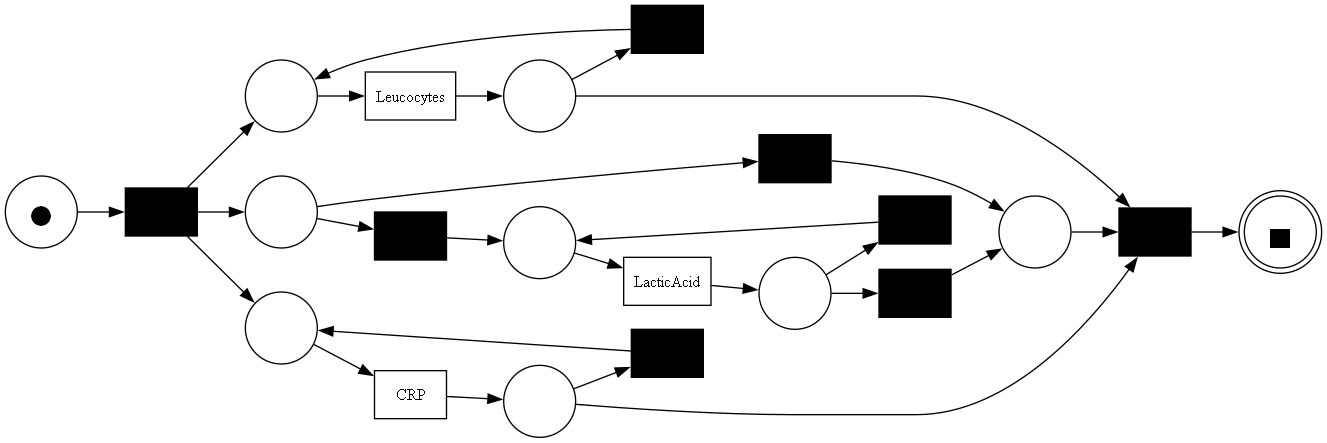

Cell (2014, 'Middle-aged', 'Test') Number of events: 106


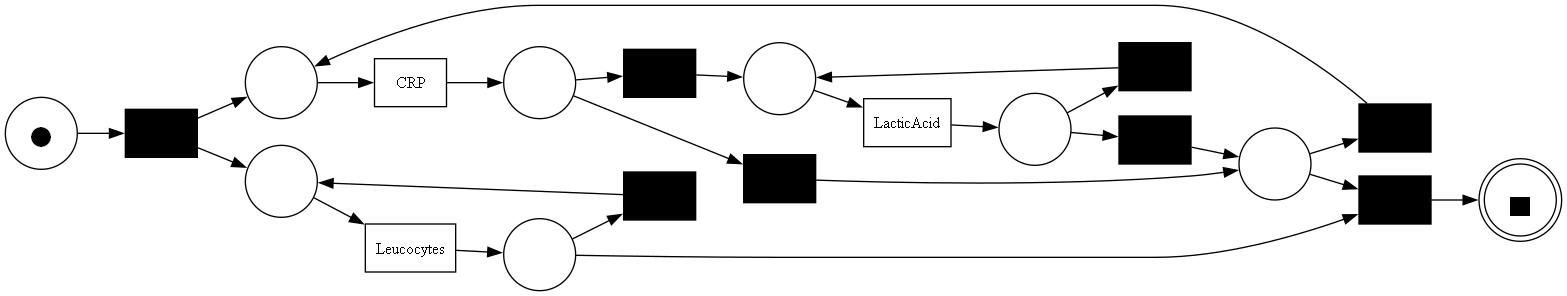

Cell (2015, 'Middle-aged', 'Test') Number of events: 63


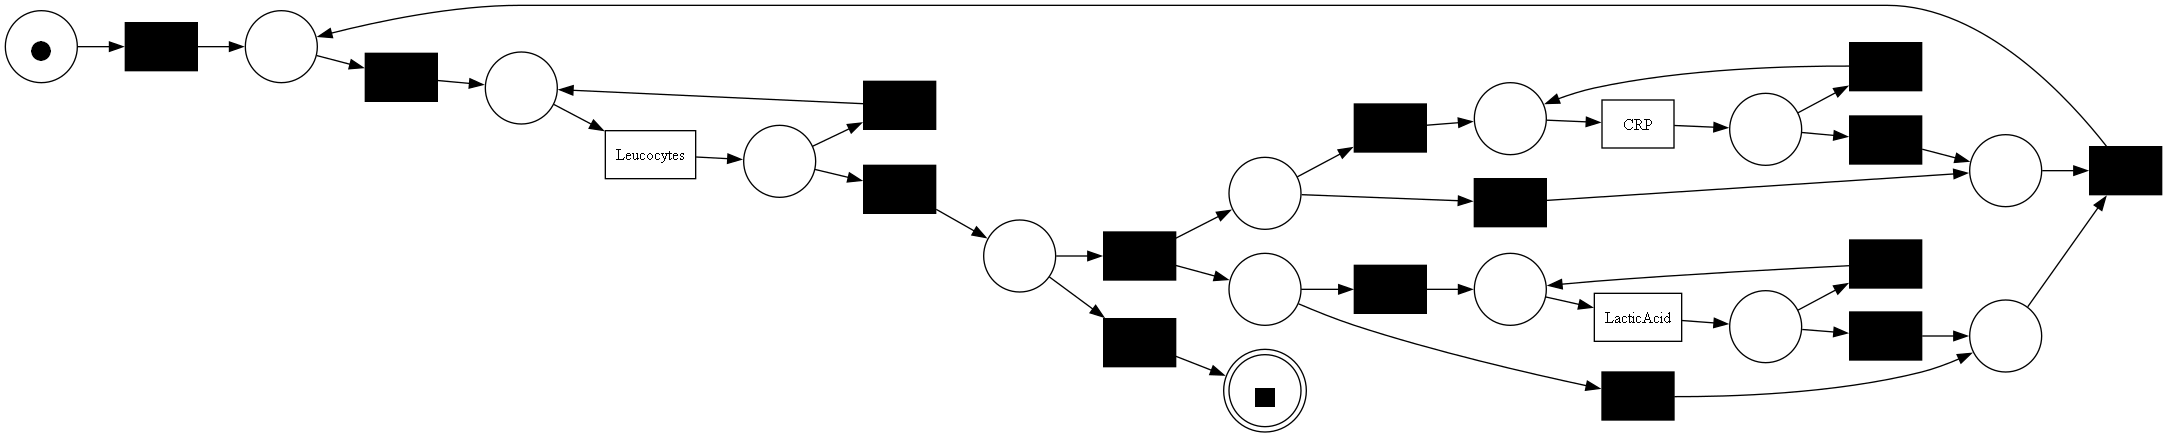

Cell (2015, 'Middle-aged', 'Admission') Number of events: 2


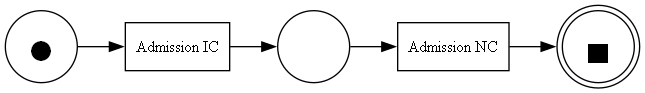

,Cell,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events,cluster_id
0,"(2013, Senior, Test)",21,26,1.238095,2.481818,6,2.476190,0.061905,3,3,48,433,1
1,"(2013, Senior, Emergency)",16,18,1.125000,2.285714,3,2.250000,0.075000,3,4,4,193,1
2,"(2014, Senior, Test)",31,38,1.225806,2.474790,8,2.451613,0.040860,3,3,263,3988,1
3,"(2014, Senior, Emergency)",18,22,1.222222,2.444444,5,2.444444,0.071895,3,4,10,1823,1
4,"(2015, Senior, Test)",26,32,1.230769,2.476190,7,2.461538,0.049231,3,3,42,345,1
5,"(2015, Senior, Emergency)",14,16,1.142857,2.285714,3,2.285714,0.087912,2,4,4,182,1
6,"(2014, Senior, Test)",21,26,1.238095,2.481818,6,2.476190,0.061905,3,3,13,774,0
7,"(2014, Middle-aged, Test)",20,24,1.200000,2.424242,5,2.400000,0.063158,2,3,3,106,0
8,"(2015, Middle-aged, Test)",32,38,1.187500,2.412698,7,2.375000,0.038306,2,3,1,63,0
9,"(2015, Middle-aged, Admission)",5,4,0.800000,1.666667,0,1.600000,0.200000,0,2,1,2,0


In [49]:
all_results = []

for cluster_id, cluster_df in cluster_logs.items():
    cluster_df = define_age_hierarchy(cluster_df)
    cluster_df = define_time_hierarchy(cluster_df)
    cluster_df = define_activity_groups(cluster_df)
    cluster_df = fill_trace_level_values(cluster_df, ['Age', 'age_group', 'age_category'])

    pcs = build_pcs()
    pcv = build_pcv(
        granularity={'time': 'month', 'age': 'age_group', 'activity': 'activity_group'},
        filters={}
    )
    pcv = rollup_pcv(pcv,pcs,'time')
    pcv = rollup_pcv(pcv,pcs,'age')
    
    mpcv = materialize_process_cube_view(cluster_df, pcs, pcv)
    print(f"Total number of Cells: {len(mpcv)}")
    for cell_key, sublog in mpcv.items():
        print(f"Cell {cell_key}: {len(sublog)} events")
    total_events = sum(len(sublog) for sublog in mpcv.values())
    print(f"Total number of events: {total_events}")

    cell_data = []

    for cell_key, sublog in mpcv.items():
        cell_data.append((*cell_key, len(sublog))) 

    df = pd.DataFrame(cell_data, columns=['year', 'age_category', 'activity_group', 'Event Count'])

    top2_per_year = (
        df.sort_values(['year', 'Event Count'], ascending=[True, False])
          .groupby('year')
          .head(2)
    )

    print(top2_per_year)
    
    cell_list = list(top2_per_year[['year', 'age_category', 'activity_group']].itertuples(index=False, name=None))
    
    models_tc_pc = discover_models_for_cells(cluster_df, cell_list)
    
    results_df_tc_pc = evaluate_models_pc(cluster_df, models_tc_pc)
    results_df_tc_pc['cluster_id'] = cluster_id
    all_results.append(results_df_tc_pc)
    
results_df_tc_pc_all = pd.concat(all_results, ignore_index=True)

results_df_tc_pc_all

# PC --> TC

## Extracting a Sublog

In [50]:
df_pc_tc = pm.convert_to_dataframe(xes)

df_pc_tc = define_age_hierarchy(df_pc_tc)
df_pc_tc = define_time_hierarchy(df_pc_tc)
df_pc_tc = define_activity_groups(df_pc_tc)
df_pc_tc = fill_trace_level_values(df_pc_tc, ['Age', 'age_group', 'age_category'])

In [51]:
pcs = build_pcs()
pcv = build_pcv(
    granularity={'time': 'year', 'age': 'age_category', 'activity': 'activity_group'},
    filters={}
)

In [52]:
mpcv = materialize_process_cube_view(df_pc_tc, pcs, pcv)

target_cell = (2014, 'Senior', 'Test')
sublog = mpcv[target_cell]

## Trace Clustering the Sublog

In [53]:
activities = sublog['concept:name'].unique()

mapping = {act: chr(97 + i) for i, act in enumerate(activities)} 
sublog['activity_mapped'] = sublog['concept:name'].map(mapping)

sublog_ordered_df = sublog.sort_values(by=["case:concept:name", "time:timestamp"]) # order by case ids
sublog_mapped_df = sublog.groupby("case:concept:name")["activity_mapped"].apply(list).reset_index() # group by case ids

In [54]:
sublog_mapped_df['activity_str'] = sublog_mapped_df['activity_mapped'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=None,                     
    token_pattern=r'(?u)\b\w+\b'         
)

X = vectorizer.fit_transform(sublog_mapped_df['activity_str'])

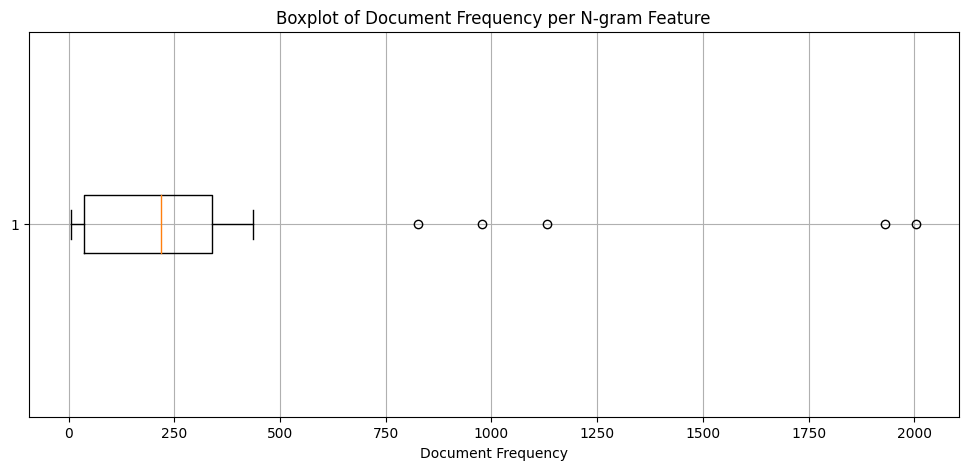

In [55]:
df_counts = np.asarray(X.sum(axis=0)).flatten()

plt.figure(figsize=(12, 5))
plt.boxplot(df_counts, vert=False)
plt.title("Boxplot of Document Frequency per N-gram Feature")
plt.xlabel("Document Frequency")
plt.grid(True)
plt.show()

In [56]:
# number of ngrams remaining after reducing

# Based on IQR
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

idx_1500 = np.where((df_counts >= lower) & (df_counts <= upper))[0]
X_IQR = X[:, idx_1500]

# Based on Boxplot
idx_500 = np.where(df_counts <= 500)[0]
X_box = X[:, idx_500]

print(f"Original number of ngrams: {X.shape[1]}")
print(f"Based on IQR: {X_IQR.shape[1]}")
print(f"Based on Box plot: {X_box.shape[1]}")

Original number of ngrams: 39
Based on IQR: 34
Based on Box plot: 34


In [57]:
#Frequency Feature Selection (IQR)

# 1. frequency of ngrams
df_counts = np.asarray(X.sum(axis=0)).flatten()

# 2. IQR 
Q1 = np.percentile(df_counts, 25)
Q3 = np.percentile(df_counts, 75)
IQR = Q3 - Q1

# 3. Lower, Upper IQR
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 4. Reduce ngrams
valid_idx = np.where((df_counts >= lower) & (df_counts <= upper))[0]

# 5. Filter
X_filtered_iqr = X[:, valid_idx]
X_svd = X_filtered_iqr
#Traces in Cluster 0: 872
#Traces in Cluster 1: 178

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


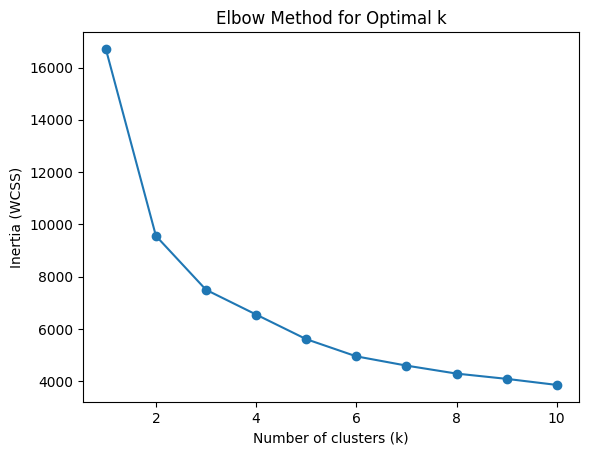

In [58]:
inertia_list = []

for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_svd)  
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1, 11), inertia_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kme

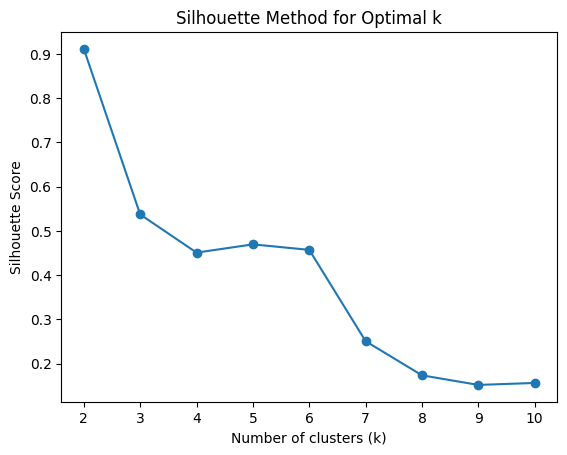

In [59]:
score = []

for i in range(2, 11) :
    km = KMeans(n_clusters = i, random_state = 10)
    km.fit(X_svd)
    pred = km.predict(X_svd)
    score.append(silhouette_score(X_svd, pred))

plt.plot(range(2, 11), score, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()


In [60]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_svd)

sublog_mapped_df['cluster'] = kmeans.labels_

c:\users\park\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [61]:
cluster_counts = sublog_mapped_df['cluster'].value_counts().sort_index()

for cluster_id, count in cluster_counts.items():
    print(f"Traces in Cluster {cluster_id}: {count}")

Traces in Cluster 0: 3
Traces in Cluster 1: 565


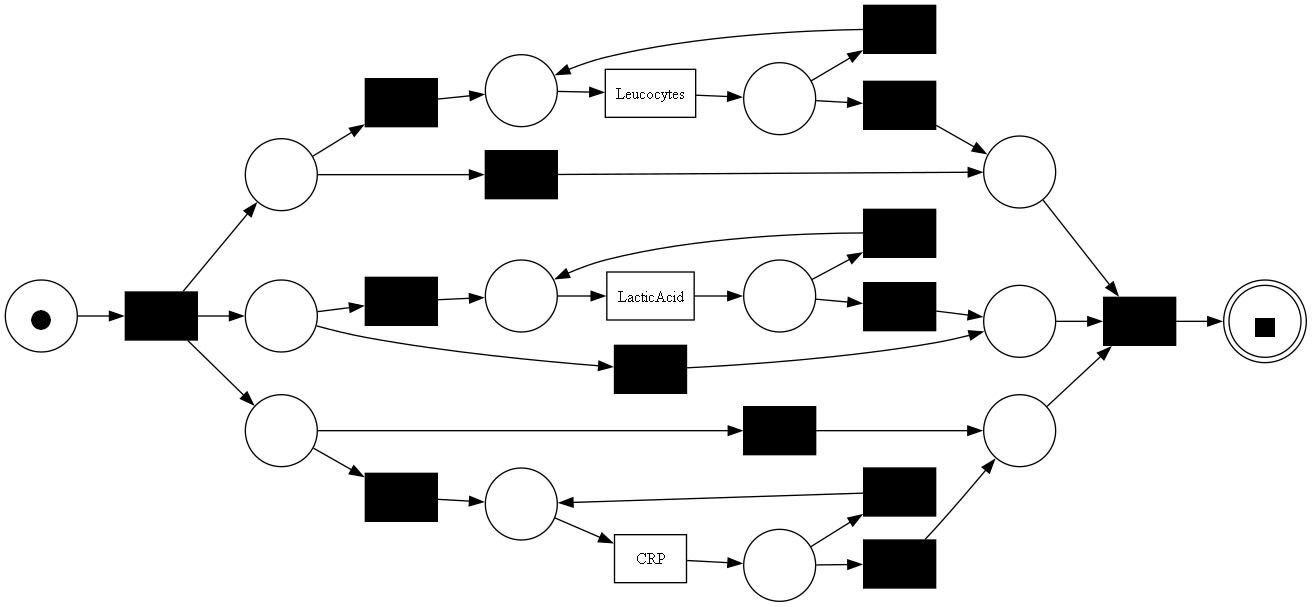

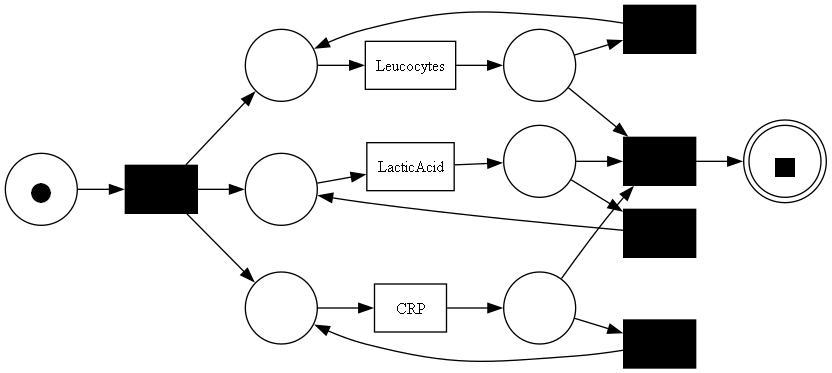

In [62]:
cluster_logs = split_event_log_by_cluster(sublog_mapped_df, sublog_ordered_df)
cluster_models = discover_process_models(cluster_logs)

In [63]:
results_df_tc = evaluate_models_cluster(
    models_dict=cluster_models,
    trace_df=sublog_mapped_df,
    full_event_df=sublog_ordered_df
)

In [64]:
results_df_tc

,Cluster,# Nodes,# Arcs,CNC,P/T-CD,Cyclomatic Number (CN),ACD,Density,CFC,# Event Classes,# Variants,# Events
0,1,31,38,1.225806,2.47479,8,2.451613,0.040860,3,3,273,4318
1,0,16,20,1.250000,2.50000,5,2.500000,0.083333,3,3,3,444
